In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
import seaborn as sns
sns.set_theme(style="ticks",rc={"axes.spines.right": False, "axes.spines.top": False})

In [2]:

# --- Load data ---
# path = "treti_vlna_ozp.csv"
path = "treti_vlna_OZP.csv"
df = pd.read_csv(path, sep=';', quotechar='"', encoding='cp1250', engine='python')

# Convert decimal commas
def to_float_series(s):
    return (
        s.astype(str)
        .str.replace(",", ".", regex=False)
        .str.replace('"', "")
        .str.strip()
        .replace("", "0")
        .astype(float)
    )

for col in ["mesic_pred", "mesic_po", "pulrok_pred", "pulrok_po", "rok_pred", "rok_po", "dva_roky_pred", "dva_roky_po"]:
    df[col] = to_float_series(df[col])

# --- Filter out 0-11 age group ---
df=df.rename(columns={"vek_pri_tretim_ockovani": "vekova_skupina"})
df = df[df['vekova_skupina'] != "0-11"]
df = df[df['vekova_skupina'] != "70+"]
df.vekova_skupina = pd.Categorical(df.vekova_skupina, 
                                   categories=["12-29", "30-49", "50-69"]) #, "70+"])


In [3]:
df.head()

,Id_pojistence,Pohlavi,vekova_skupina,vlna3,mesic_pred,mesic_po,pulrok_pred,pulrok_po,rok_pred,rok_po,dva_roky_pred,dva_roky_po,datum_predpisu,datum_ockovani,dny_do_prvniho_predpisu
0,2,M,30-49,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2022-01-10,NaN
2,6,F,50-69,2,50.0,50.0,50.0,100.0,50.0,150.0,50.0,250.0,2015-02-25,2021-12-06,-2476.0
3,8,M,12-29,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2022-01-12,NaN
4,10,M,50-69,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2021-12-22,NaN
5,21,F,12-29,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,2022-01-07,NaN


In [4]:

# --- Time windows ---
windows = [
    ("mesic_pred", "mesic_po", "month"),
    ("pulrok_pred", "pulrok_po", "half_year"),
    ("rok_pred", "rok_po", "year"),
    ("dva_roky_pred", "dva_roky_po", "two_year")
]
nsamples = 20000
epsilon = 1e-12

# --- Bayesian bootstrap function ---
def bayes_bootstrap_ratio(x_before, x_after, nsamples=20000, epsilon=1e-12):
    vals_b, counts_b = np.unique(x_before, return_counts=True)
    vals_a, counts_a = np.unique(x_after, return_counts=True)
    ratio_samples = np.empty(nsamples)
    for i in range(nsamples):
        g_b = np.random.gamma(shape=counts_b, scale=1.0)
        g_a = np.random.gamma(shape=counts_a, scale=1.0)
        w_b = g_b / g_b.sum()
        w_a = g_a / g_a.sum()
        mean_b = np.sum(vals_b * w_b)
        mean_a = np.sum(vals_a * w_a)
        # Adjustment so that 0/0 -> 1
        ratio_samples[i] = (mean_a + epsilon) / (mean_b + epsilon)
    return ratio_samples


In [5]:

# --- Groups (age × treatment) ---
group_keys = sorted(df[['vekova_skupina', 'vlna3']].drop_duplicates().values.tolist())

# --- Compute posteriors ---
posteriors = {wname: {} for _, _, wname in windows}

for before_col, after_col, wname in windows:
    for age, treat in group_keys:
        mask = (df['vekova_skupina'] == age) & (df['vlna3'].astype(float) == float(treat))
        x_before = df.loc[mask, before_col].values
        x_after  = df.loc[mask, after_col].values
        posteriors[wname][(age, treat)] = bayes_bootstrap_ratio(x_before, x_after, nsamples=nsamples, epsilon=epsilon)


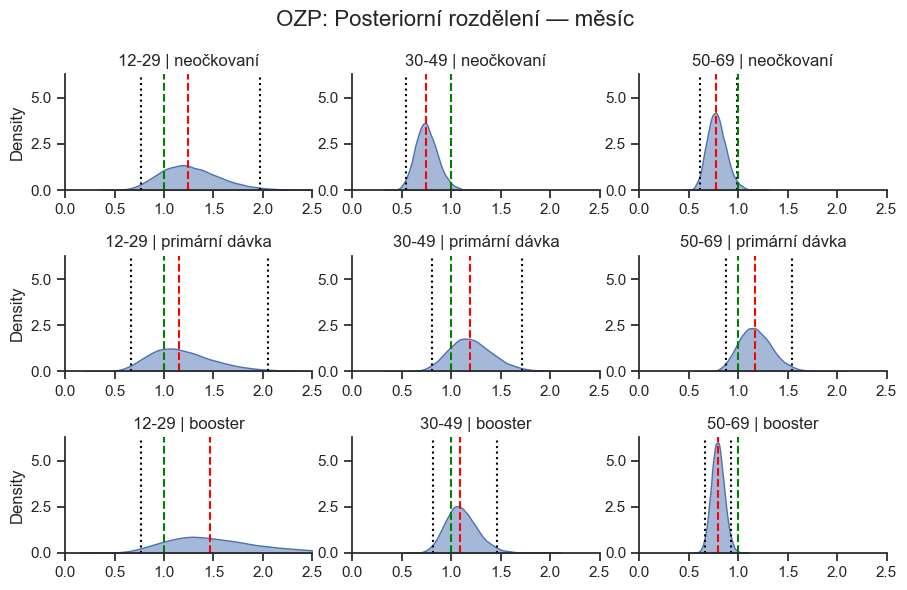

In [6]:

# --- Plot each time window separately ---
# for "week" in ["week", "two_weeks", "month"]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9, 6), sharex=True, sharey=True)
fig.suptitle(f"OZP: Posteriorní rozdělení — měsíc", fontsize=16)

# Sort by treatment (rows) and age group (cols)
age_groups_sorted = sorted(set(df['vekova_skupina']))

treat_sorted = sorted(set(df['vlna3']))
treat_names = ["neočkovaní","primární dávka","booster"]

for r, treat in enumerate(treat_sorted):
    for c, age in enumerate(age_groups_sorted):
        ax = axes[r, c]
        samples = posteriors["month"][(age, treat)]
        # ax.hist(samples, bins=100, density=True, color="skyblue", edgecolor="k")
        sns.kdeplot(samples, ax=ax, fill=True, alpha=0.5)
        med = np.median(samples)
        lo, hi = np.percentile(samples, [2.5, 97.5])
        ax.axvline(med, linestyle="--", color="red")
        ax.axvline(lo, linestyle=":", color="black")
        ax.axvline(hi, linestyle=":", color="black")
        ax.axvline(1, linestyle="--", color="green")
        ax.set_title(f"{age} | {treat_names[r]}")
        ax.set_xlim([0, 2.5])
        ax.tick_params(axis="both",which="both",labelbottom=True, labelleft=True)
plt.tight_layout()
plt.savefig("grafy_python/ozp_posterior_treti_mesic", dpi=300)  # Save as PNG with high resolution
plt.show()


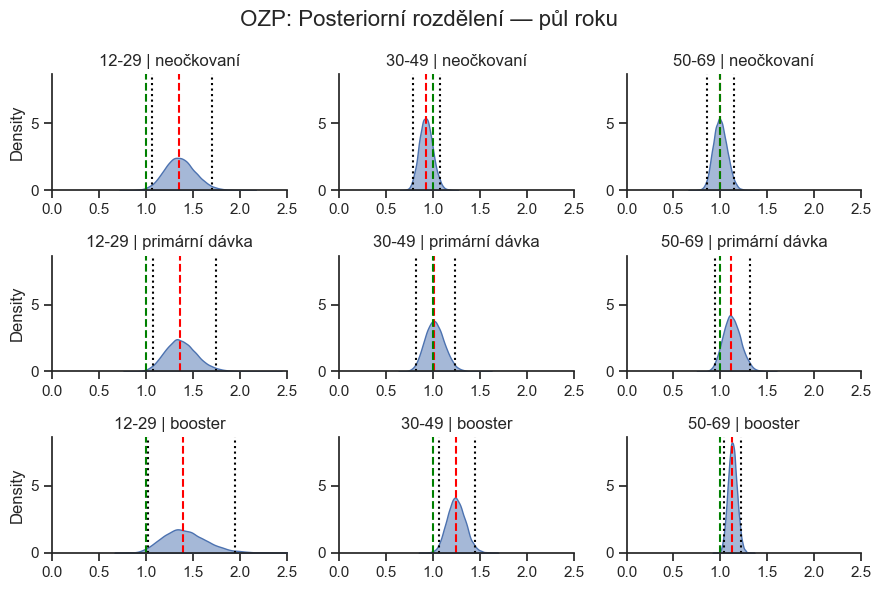

In [7]:

# --- Plot each time window separately ---
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,6), sharex=True, sharey=True)
fig.suptitle(f"OZP: Posteriorní rozdělení — půl roku", fontsize=16)

# Sort by treatment (rows) and age group (cols)
age_groups_sorted = sorted(set(df['vekova_skupina']))

treat_sorted = sorted(set(df['vlna3']))
treat_names = ["neočkovaní","primární dávka","booster"]

for r, treat in enumerate(treat_sorted):
    for c, age in enumerate(age_groups_sorted):
        ax = axes[r, c]
        samples = posteriors["half_year"][(age, treat)]
        # ax.hist(samples, bins=100, density=True, color="skyblue", edgecolor="k")
        sns.kdeplot(samples, ax=ax, fill=True, alpha=0.5)
        med = np.median(samples)
        lo, hi = np.percentile(samples, [2.5, 97.5])
        ax.axvline(med, linestyle="--", color="red")
        ax.axvline(lo, linestyle=":", color="black")
        ax.axvline(hi, linestyle=":", color="black")
        ax.axvline(1, linestyle="--", color="green")
        ax.set_title(f"{age} | {treat_names[r]}")
        ax.set_xlim([0, 2.5])
        ax.tick_params(axis="both",which="both",labelbottom=True, labelleft=True)
plt.tight_layout()
plt.savefig("grafy_python/ozp_posterior_treti_pulrok", dpi=300)  # Save as PNG with high resolution
plt.show()


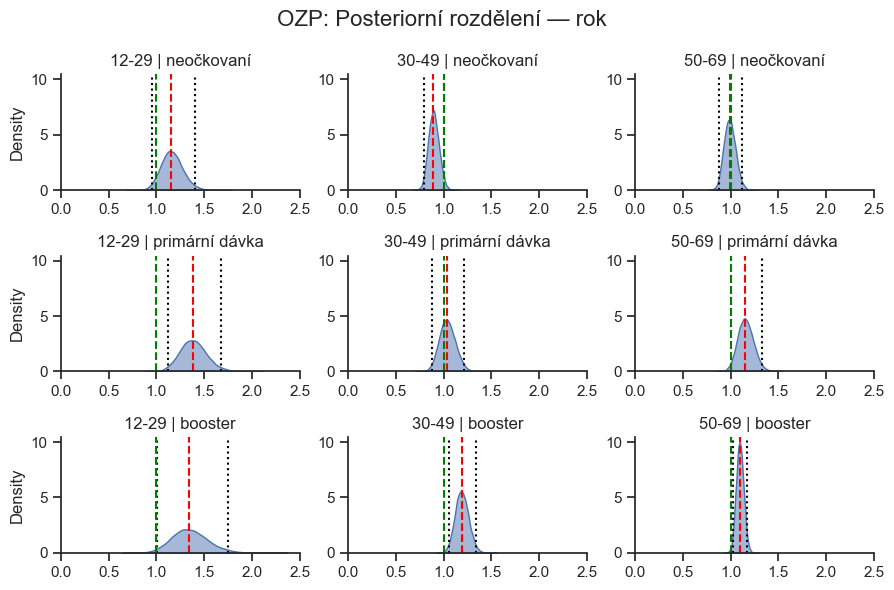

In [8]:

# --- Plot each time window separately ---
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,6), sharex=True, sharey=True)
fig.suptitle(f"OZP: Posteriorní rozdělení — rok", fontsize=16)

# Sort by treatment (rows) and age group (cols)
age_groups_sorted = sorted(set(df['vekova_skupina']))

treat_sorted = sorted(set(df['vlna3']))
treat_names = ["neočkovaní","primární dávka","booster"]

for r, treat in enumerate(treat_sorted):
    for c, age in enumerate(age_groups_sorted):
        ax = axes[r, c]
        samples = posteriors["year"][(age, treat)]
        # ax.hist(samples, bins=100, density=True, color="skyblue", edgecolor="k")
        sns.kdeplot(samples, ax=ax, fill=True, alpha=0.5)
        med = np.median(samples)
        lo, hi = np.percentile(samples, [2.5, 97.5])
        ax.axvline(med, linestyle="--", color="red")
        ax.axvline(lo, linestyle=":", color="black")
        ax.axvline(hi, linestyle=":", color="black")
        ax.axvline(1, linestyle="--", color="green")
        ax.set_title(f"{age} | {treat_names[r]}")
        ax.set_xlim([0, 2.5])
        ax.tick_params(axis="both",which="both",labelbottom=True, labelleft=True)
plt.tight_layout()
plt.savefig("grafy_python/ozp_posterior_treti_rok", dpi=300)  # Save as PNG with high resolution
plt.show()


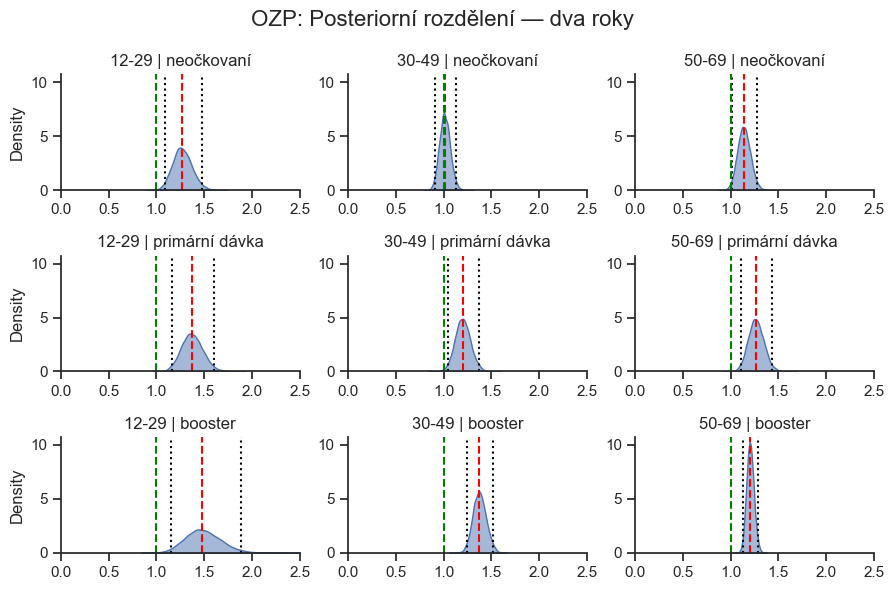

In [9]:

# --- Plot each time window separately ---
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(9,6), sharex=True, sharey=True)
fig.suptitle(f"OZP: Posteriorní rozdělení — dva roky", fontsize=16)

# Sort by treatment (rows) and age group (cols)
age_groups_sorted = sorted(set(df['vekova_skupina']))

treat_sorted = sorted(set(df['vlna3']))
treat_names = ["neočkovaní","primární dávka","booster"]

for r, treat in enumerate(treat_sorted):
    for c, age in enumerate(age_groups_sorted):
        ax = axes[r, c]
        samples = posteriors["two_year"][(age, treat)]
        # ax.hist(samples, bins=100, density=True, color="skyblue", edgecolor="k")
        sns.kdeplot(samples, ax=ax, fill=True, alpha=0.5)
        med = np.median(samples)
        lo, hi = np.percentile(samples, [2.5, 97.5])
        ax.axvline(med, linestyle="--", color="red")
        ax.axvline(lo, linestyle=":", color="black")
        ax.axvline(hi, linestyle=":", color="black")
        ax.axvline(1, linestyle="--", color="green")
        ax.set_title(f"{age} | {treat_names[r]}")
        ax.set_xlim([0, 2.5])
        ax.tick_params(axis="both",which="both",labelbottom=True, labelleft=True)
plt.tight_layout()
plt.savefig("grafy_python/ozp_posterior_treti_dvaroky", dpi=300)  # Save as PNG with high resolution
plt.show()


In [10]:
# --- Summaries per group ---
def summarize_posteriors(posteriors):
    summaries = {}
    for window, groups in posteriors.items():
        rows = []
        for (age, treat), samples in groups.items():
            median = np.median(samples)
            ci_lower, ci_upper = np.percentile(samples, [2.5, 97.5])
            p_greater_1 = np.mean(samples > 1)
            rows.append([age, treat, median, ci_lower, ci_upper, p_greater_1])
        summaries[window] = pd.DataFrame(rows, columns=[
            "Age_group", "Treatment", "Median_ratio", "CI_lower", "CI_upper", "P(ratio>1)"
        ])
    return summaries

# --- Ratio-of-Ratios (treated vs untreated) ---
def summarize_ror(posteriors, reference_group=0):
    """Compute RoR relative to reference_group (default untreated=0)."""
    ror_summaries = {}
    for window, groups in posteriors.items():
        rows = []
        for age in set(k[0] for k in groups.keys()):
            if (age, reference_group) not in groups:
                continue
            ref_samples = groups[(age, reference_group)]
            for treat in sorted(set(t for (_, t) in groups.keys() if t != reference_group)):
                if (age, treat) not in groups:
                    continue
                treat_samples = groups[(age, treat)]
                ror_samples = treat_samples / ref_samples
                median = np.median(ror_samples)
                ci_lower, ci_upper = np.percentile(ror_samples, [2.5, 97.5])
                p_greater_1 = np.mean(ror_samples > 1)
                rows.append([age, treat, median, ci_lower, ci_upper, p_greater_1])
        ror_summaries[window] = pd.DataFrame(rows, columns=[
            "Age_group", "Treatment_vsRef", "Median_RoR", "CI_lower", "CI_upper", "P(RoR>1)"
        ])
    return ror_summaries

# --- Posterior comparisons ---
def summarize_comparisons(posteriors):
    comp_summaries = {}
    for window, groups in posteriors.items():
        rows = []
        for age in set(k[0] for k in groups.keys()):
            age_groups = {t: groups[(age, t)] for (a, t) in groups if a == age}
            treatments = sorted(age_groups.keys())
            # pairwise comparisons
            if len(treatments) >= 2:
                # untreated vs treated
                if 0 in treatments and 2 in treatments:
                    p = np.mean(age_groups[0] > age_groups[2])
                    rows.append([age, "P(untreated > treated)", p])
                # treated-once vs treated
                if 1 in treatments and 2 in treatments:
                    p = np.mean(age_groups[1] > age_groups[2])
                    rows.append([age, "P(treatedonce > treated)", p])
                #moje
                if 0 in treatments and 1 in treatments:
                    p = np.mean(age_groups[0] > age_groups[1])
                    rows.append([age, "P(untreated > treatedonce)", p])
            # if only 2 groups exist, this still works
        comp_summaries[window] = pd.DataFrame(rows, columns=["Age_group", "Comparison", "Probability"])
    return comp_summaries

In [11]:
summaries      = summarize_posteriors(posteriors)      # per group
ror_summaries  = summarize_ror(posteriors, reference_group=0)  # RoR vs untreated
comp_summaries = summarize_comparisons(posteriors)     # posterior comparisons

# Save all summaries
for w, summ in summaries.items():
    summ.round(2).to_csv(f"summary_{w}.csv", index=False)
for w, summ in ror_summaries.items():
    summ.round(2).to_csv(f"summary_ror_{w}.csv", index=False)
for w, summ in comp_summaries.items():
    summ.round(2).to_csv(f"summary_comp_{w}.csv", index=False)

In [12]:
print(ror_summaries['month'].round(2))

  Age_group  Treatment_vsRef  Median_RoR  CI_lower  CI_upper  P(RoR>1)
0     30-49                1        1.60      0.98      2.57      0.97
1     30-49                2        1.47      0.98      2.23      0.97
2     12-29                1        0.93      0.45      1.97      0.42
3     12-29                2        1.18      0.52      2.71      0.66
4     50-69                1        1.50      1.04      2.17      0.99
5     50-69                2        1.02      0.76      1.37      0.55


In [13]:
print(ror_summaries['month'].sort_values(by=['Treatment_vsRef','Age_group']))

  Age_group  Treatment_vsRef  Median_RoR  CI_lower  CI_upper  P(RoR>1)
2     12-29                1    0.928256  0.453863  1.966621   0.42085
0     30-49                1    1.598356  0.982446  2.569952   0.97085
4     50-69                1    1.499336  1.042414  2.166812   0.98590
3     12-29                2    1.178073  0.523020  2.710913   0.65965
1     30-49                2    1.469162  0.981156  2.232646   0.96880
5     50-69                2    1.017497  0.757410  1.369974   0.54795


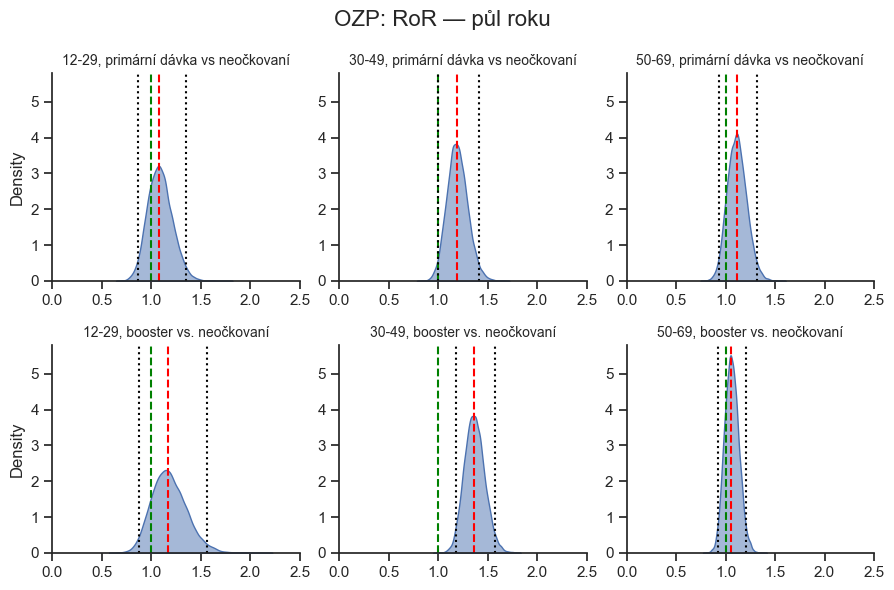

In [17]:

window = "two_year"  # Change to "half_year", "year", or "two_year" as needed
# Plot RoR distributions for each age group and treatment
fig, axes = plt.subplots(2, 3, figsize=(9,6), sharex=True, sharey=True)
fig.suptitle(f"OZP: RoR — půl roku", fontsize=16)

axes = axes.flatten()
nazvy_grafu = ["primární dávka vs neočkovaní","primární dávka vs neočkovaní","primární dávka vs neočkovaní",
               "booster vs. neočkovaní","booster vs. neočkovaní","booster vs. neočkovaní"]

for i, (age, treat) in enumerate(ror_summaries[window].sort_values(by=['Treatment_vsRef','Age_group'])[["Age_group","Treatment_vsRef"]].values):
    ax = axes[i]
    ref = posteriors[window][(age, 0)]  # untreated
    treat_samples = posteriors[window][(age, treat)]
    ror_samples = treat_samples / ref
    
    sns.kdeplot(ror_samples, ax=ax, fill=True, alpha=0.5)
    # ax.hist(ror_samples, bins=100, density=True, color="skyblue", edgecolor="k")
    ax.axvline(1, color="green", linestyle="--")
    ax.set_title(f"{age}, {nazvy_grafu[i]}", fontsize=10)
    ax.tick_params(axis="both",which="both",labelbottom=True, labelleft=True)
    ax.set_xlim([0, 2.5])
    med = np.median(ror_samples)
    lo, hi = np.percentile(ror_samples, [2.5, 97.5])
    ax.axvline(med, linestyle="--", color="red")
    ax.axvline(lo, linestyle=":", color="black")
    ax.axvline(hi, linestyle=":", color="black")

plt.savefig("grafy_python/ozp_ror_treti_dva_roky", dpi=300)  # Save as PNG with high resolution
plt.tight_layout()
plt.show()
